# Résumé

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import math
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import diagnostic
import scipy as sp
import networkx as nx
import ast
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
# from sklearn.preprocessing import OneHotEncoder
# from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

my_palette = sns.color_palette(["#427AA1", "#6F84D8", "#98DFEA", "#EE8434", "#B02E0C"])
sns.set_palette(my_palette)

In [2]:
dic={"col1":[1,2,3,5,3,2], "col2":[2,5,4,5,4,1], "col3":[12,3,4,12,4,1], "Type":['a', 'a', 'b', 'c', 'b', 'a']}
df = pd.DataFrame(dic)

## Manipulation des arrays

In [3]:
# Regular expressions
text = "Bonjourtoken1je cherche des patatestoken2En avez-vous vutoken1"
tokens = ["token1", "token2"]
pattern = '|'.join(map(re.escape, tokens))
words = re.split(pattern, text)

# Retirer les données d'un array correpondant à un certain item
np.delete(words, np.where(words=='test'))

C:\Users\paul\AppData\Local\Temp/ipykernel_19188/1305496724.py:8: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  np.delete(words, np.where(words=='test'))


array(['Bonjour', 'je cherche des patates', 'En avez-vous vu', ''],
      dtype='<U22')

## Manipulation des DataFrames



In [4]:
#Loading
columns = ['col1','col2']
df_b = pd.read_csv('PATH', columns=columns)

# Changing the name of a column
df.rename({'Type_a': 'a'}, axis = 1, inplace=True)
# changing the name of an index
df.rename({0:'init'}, inplace=True)
# Set a new index
df.set_index('col1', inplace=True) #CAREFUL, you have to check that 

# Créer une nouvelle colonne avec des données particulières
# issues d'un passage ligne par ligne dans le dataframe
df['Nouvelle colonne'] = 0
for index, row in df.iterrows():
    df.at[index, 'Nouvelle colonne'] = row["col2"]+row["col3"]
# Create a new column depending on presence in a column of a name
df['Type_a'] = ['a' in data_type.lower() for data_type in df['Type']]

# Valeurs manquantes
df['col2'].isna().mean() #moyenne
df.fillna('Unknown', inplace=True) # Remplacer NaN par une valeur
df.dropna(columns=['col1','col2'],inplace=True) # Retirer les row où il y a des NaN

# Récupérer le nombre de catégories différentes
len(df['Type'].unique())

# Query composé : ( and = & ; or = | )
df.query("Type == 'A' | col3 == 12 ")

# Hot-encoding brutal
encoded_df = pd.get_dummies(df)
# Hot-encoding spécifique
df['Type_a'] = df['Type'].apply(lambda x: 1 if x=='a' else 0)#.drop(columns='Type')



TypeError: read_csv() got an unexpected keyword argument 'columns'

In [207]:
len(df['Type'].unique())

3

## Graphiques

In [ ]:
# Plot classique avec erreurs

z = 1.96 #z-score for 95% confidence intervals
indexes = df.index
y_mean = df["mean"]
y_error = z*df["std"]

plt.figure(figsize=(14,10))
#plt.errorbar(indexes, y_mean, yerr = y_error, capsize= 3)
plt.plot(indexes, y_mean)
plt.fill_between(x=indexes, y1=y_mean-y_error, y2=y_mean+y_error, alpha=0.5)
plt.xlabel("Year")
plt.ylabel("Mean worldwide gross revenue ($)")
plt.title("Mean worldwide gross against time")
plt.show()

###############################################
# Density
sns.jointplot(x=movies['worldwide_gross'], y=movies['imdb_rating'], kind="hex") # reg, kde

###############################################
# Deux variables
plt.scatter(df['col1'], df['col2'], s = 2, c='r')

# Avec régression linéaire
sns.lmplot(x='col1',y='col2', data=df)
sns.lmplot(x='col1',y='col2', data=df, hue="col4")

# Heatmap
df2 = pd.crosstab(df['col1'], df['col2'])
sns.heatmap(df2, annot=True, vmin = 0, vmax = 5)

###############################################


###############################################
# Une variable continue divisées en sous-catégories
sns.barplot(x="col4", y="col2", data=df.loc[df['col4'].isin(['a', 'b'])])
sns.boxplot(x="col4", y="col2", data=df.loc[df['col4'].isin(['a', 'b'])])
sns.violinplot(x="col4", y="col2", data=df.loc[df['col4'].isin(['a', 'b'])])

# Histogramme d'une donnée pour plusieurs catégories (16 subplots)
m=4
n=4
fig, ax = plt.subplots(m,n,figsize= (8,6), sharey = True, sharex = True)

for i in range(m*n):
    sub_figure = ax[i%m,i//n]
    sub_figure.hist(df.iloc[i].values, range = [0,200], bins = 20)
    sub_figure.set_title(df.index[i])
    
fig.tight_layout()

fig.text(0.5,0, "X_LABEL")
fig.text(0,0.5, "Occurences", rotation = 90)

# Easier : scatter plot (makes all possible pairwise tests)
sns.pairplot(df)

####################################################
# Visualisation de power laws en log/loglog scale
hist_array = plt.hist(df["col3"],bins=5,log=True,histtype='step')
plt.loglog(hist_array[1][1:],hist_array[0])

## Analyse statistique

#### Analyse naive de premier stade

In [ ]:
# print(f"The mean  of the treated group is {df['col1']}")
print("The mean  of the treated group is {}".format(df['col1']))
sns.barplot(x="col1", y="col2", data=df, capsize = 0.1)
plt.ylabel("col1")
plt.xlabel("col2")
plt.show()

In [132]:
# Correspondance d'une distribution d'une variable avec des distributions connues
diagnostic.kstest_normal(df['col2'].values, dist = 'norm')#'exp'

# Correlation (coeff_correlation + p-value)
sp.stats.pearsonr(df['col1'], df['col2']) #linéaire
sp.stats.spearmanr(df['col1'], df['col2']) # monotonie (corrélation de rang)

# Vérifier que deux distributions sont significativement différentes : t-test
data1 = df["col1"]
data2 = df["col2"]
ttest, pvalue  =  sp.stats.ttest_ind(data1, data2)

if pvalue>0.05:
    print(f"The difference between both distribution is not significant (p-value = {pvalue} > 0.05).")
else:
    if data1.mean()>data2.mean():
        print(f"Data 1 is significantly higher than data 2.")
    elif data1.mean()<data32.mean():
        print(f"Data 1 si singificantly smaller than data 2.")
    print(f"(p-value = {pvalue} < 0.05)")


#

The difference between both distribution is not significant (p-value = 0.36199658232804666 > 0.05).


## Régressions

#### Linéaire
- Equations are specified using patsy formula syntax. Important operators are:
    1. `~` : Separates the left-hand side and right-hand side of a formula.
    2. `+` : Creates a union of terms that are included in the model.
    3. `:` : Interaction term.
    3. `*` : `a * b` is short-hand for `a + b + a:b`, and is useful for the common case of wanting to include all interactions between a set of variables.

- Intercepts are added by default.

- Categorical variables can be included directly by adding a term C(a). This make the regression considering the influence of subvariables `being of type 1 or not`, `being of type 2 or not`, etc.

In [121]:
#Data (predictor 1 is continuous, predictor 2 is categorical)
pred1 = 'Predictor1'
pred2 = 'Predictor2'
outcome = 'Outcome'
dic = {pred1:[12,3,4,10,6,3,6,5,8,7,4,5,2,3,6,8,2,7,1,9],
       pred2:['A','A','B','C','B','A','B','C','A','C','A','A','C','B','B','B','C','C','C','B'],
       outcome:[7,2,2,8,4,1,5,5,6,4,3,5,0,3,5,7,0,8,0,7]}
df_reg = pd.DataFrame(dic)

# ordinary least squares linear regression
mod = smf.ols(formula=f"{outcome} ~  {pred1} + C({pred2})", data=df_reg)
np.random.seed(42)
res = mod.fit()
#print(res.summary())

#Display the regression equation
regressive_coef = round(res.params,3)
reg_eq = f"{outcome} = {regressive_coef[0]}"
for pred in regressive_coef.index[1:]:# We get rid of the intercept
    param = regressive_coef[pred]
    if param>=0:
        reg_eq += f' +'
    reg_eq += f" {regressive_coef[pred]} * {pred}"
print(reg_eq)

Outcome = -0.78 + 0.578 * C(Predictor2)[T.B] + 0.371 * C(Predictor2)[T.C] + 0.819 * Predictor1


#### Logistic regression

- Remember : logistic regression is used to modelize **binary** outcome.

- First, standardize continous outcome in order to get every predictor on a similar scale (this will prevent artificial influence of predictors

- Then we extract value of each logisitc coefficient. If equal 0, it means it do not help understanding if the outcome is going to be 0 or 1.

Optimization terminated successfully.
         Current function value: 0.339265
         Iterations 7


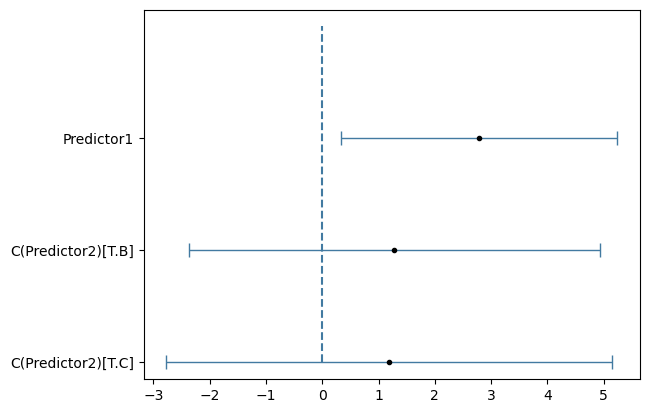

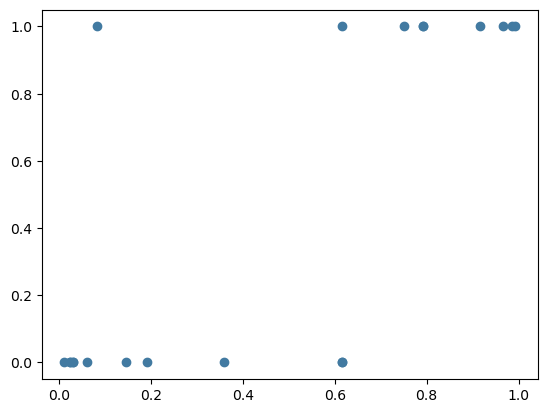

In [96]:
# Adding a binary outcome
bin_out = 'Binary_outcome'
df_reg_standardized=df_reg.copy(deep=True)
df_reg_standardized[bin_out]=[1,0,0,1,0,0,0,0,1,1,0,0,0,1,1,1,0,1,0,1]

# Standardization of each continuous variable:
continuous = [outcome, pred1]
for predictor in continuous:
    df_reg_standardized[predictor]=(df_reg[predictor]-df_reg[predictor].mean())/df_reg[predictor].std()

#####################  StandardScaler().fit(df).transform(df) => pour la standardisation

# Logistic regression
mod = smf.logit(formula=f"{bin_out} ~  {pred1} + C({pred2})", data=df_reg_standardized)
np.random.seed(42)
res = mod.fit()
#print(res.summary())

# sorting coefficients from the highest to the smalles (excluding intercept !!!)

variables = res.params.index # feature names
coefficients = res.params.values # coefficients
p_values = res.pvalues # p-values
standard_errors = res.bse.values # standard errors
confidence_intervals = res.conf_int() #confidence intervals

#Here we choose to plot confidence intervals
coefficients, variables, p_values, standard_errors = zip(*sorted(zip(coefficients[1:],
                                                        variables[1:], standard_errors[1:], p_values[1:])))

# Superbe plot to understand significance of each parameter
# fancy plotting
plt.errorbar(coefficients, np.array(range(len(coefficients))), xerr= 2*np.array(p_values), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)
plt.vlines(0,0, len(coefficients), linestyle = '--')
plt.yticks(range(len(variables)),variables)
plt.show()

# Adding prediction score to the dataframe
df_reg_standardized['Propensity_score'] = res.predict()
plt.scatter(df_reg_standardized['Propensity_score'], df_reg_standardized['Binary_outcome'])

## Observational study

- Propensity score : probability of being in the treatment group or in the control group. It depends only of the input variables, and certainly not of the observed outcome !

#### Matching

- We hope to see if two points having similar history (so quasi-equal propensity scores) have significatively different results if one is in the treatment and the other in the control group. For this, we want to do a good matching.

In [113]:
def propensity_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for two datapoints with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)


# Separation of treatment and control groups
treatment_df = df_reg_standardized.loc[df_reg_standardized[bin_out] == 1]
control_df = df_reg_standardized.loc[df_reg_standardized[bin_out] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():
        #Possibility of adding a condition to ensure exact matching of some features...
        #if (treatment_df[predictor2]==control_df[predictor2]):
            # Calculate the similarity 
            similarity = propensity_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])
            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_df = df_reg_standardized.iloc[matched]

print(matching)
print(balanced_df)

{(10, 8), (6, 14), (13, 16), (9, 12), (7, 19), (4, 15), (2, 3), (1, 0), (17, 11)}
    Predictor1 Predictor2   Outcome  Binary_outcome  Propensity_score
10   -0.532553          A -0.414516               0          0.061499
6     0.154612          B  0.339150               0          0.615030
13   -0.876136          B -0.414516               1          0.082972
9     0.498195          C -0.037683               1          0.791320
7    -0.188970          C  0.339150               0          0.358659
4     0.154612          B -0.037683               0          0.615030
2    -0.532553          B -0.791349               0          0.190682
1    -0.876136          A -0.791349               0          0.024547
17    0.498195          C  1.469648               1          0.791320
8     0.841778          A  0.715982               1          0.750808
14    0.154612          B  0.339150               1          0.615030
16   -1.219719          C -1.545015               0          0.030700
12   -1.

## Machine learning

Please remind that ***the only avaliable data comes from training set***. So nothing can be done out of it.

#### Supervised learning

Outcomes are known, and we try to be as close as possible from this imposed outcome.

In [154]:
# Split between train and test data
percentage_train = 0.8
train_df = df.sample(n=int(np.floor(percentage_train*len(df))))#frac
test_df = df[~df.index.isin(train_df.index)]

In [124]:
# Simple linear regression
outcome = 'Outcome'
X = df_reg[['Predictor1','Predictor1']]
y = df_reg[outcome]

# Training of a linear model
lin_reg = LinearRegression()
lin_reg.fit(X, y)

#Display the regression equation
regressive_coef = np.round(lin_reg.coef_,3)
reg_eq = f"{outcome} = {round(lin_reg.intercept_,3)}"
for i,predictor in enumerate(X.columns):
    param = regressive_coef[i]
    if param>=0:
        reg_eq += f' +'
    reg_eq += f" {param} * {predictor}"
print(reg_eq)

# Sol 2
for f in range(len(X.columns)):
    print("{0} * {1} + ".format(lin_reg.coef_[f], X.columns[f]))
print(lin_reg.intercept_)


Outcome = -0.448 + 0.41 * Predictor1 + 0.41 * Predictor1


The mean squared error is 1.8483182392457027


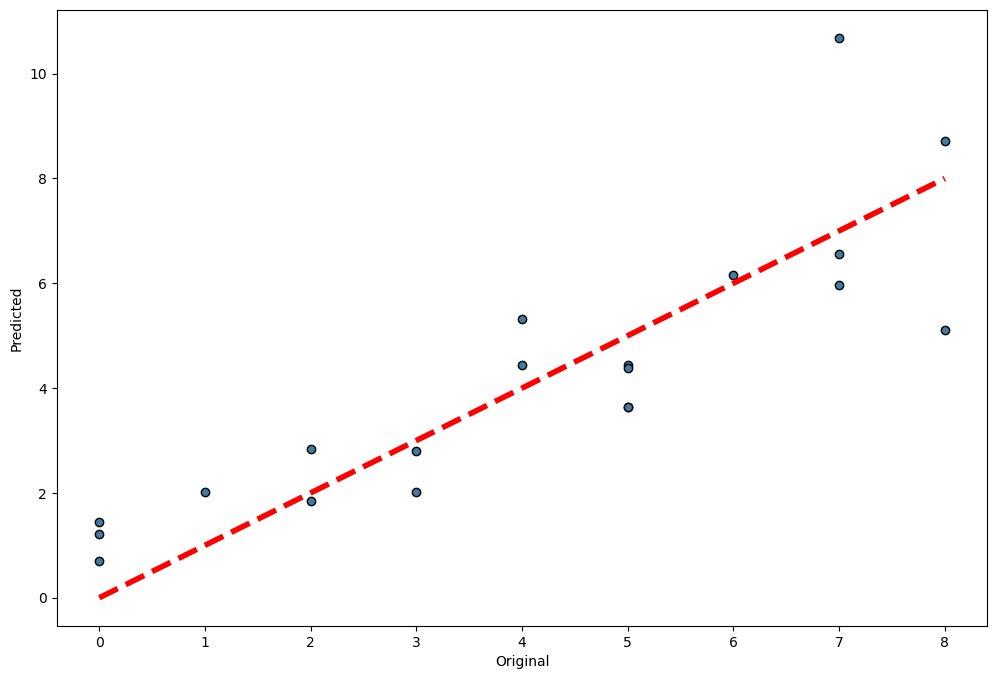

In [130]:
# Looking at prediction accuracy with cross validation
model = LinearRegression()
#model = Ridge(alpha=6) # Penalize large coefficients 
                            #(so should reduce overfitting where 1 parameter encodes strongly 1 datapoint)
predicted = cross_val_predict(model, X, y, cv=5)
print("The mean squared error is "+str(mean_squared_error(y, predicted)))
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()


#### Unsupervised learning
Here, the outcome is unknown and we hope to find it back to better understand our data

In [ ]:
def plot_sse(features_X, start=2, end=11):
    """Implementation of Elbow method to determine the optimal K for K-mean method"""
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")

#################
# Silouette method, to find the optimal K achieveing the desired tradeoff 
# between the number of clusters and cohesion/separation.
silhouettes = []

# Try multiple k
for k in range(2, 11):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(X)
    # Get the Silhouette score
    score = silhouette_score(X, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.title("Silouette curve")
#########################################@

# Use of K-mean (with proposed value of cluster)
# Can use reduced_df (by PCA of TNSE) if needed, to avoid curse of dimentionality
labels = KMeans(n_clusters=3, random_state=0).fit_predict(df)
plt.scatter(df['col1'], df['col2'], c=labels, alpha=0.6)

# Use of DBSCAN (with a value eps)
labels = DBSCAN(eps=0.05).fit_predict(df)


#### Confusion matrix and performances

- TP : true positive (outcome '1' predicted as '1')
- TN : true negative (outcome '0' predicted as '0')
- FP : false positive (outcome 'O' predicted as '1') => very bad for quality validation
- FN : false negative (outcome '1' predicted as '0') => very bad for cancer diagnostic

- **Accuracy** : rightly predicted ratio (useful when balanced predictions)
- **Precision** : rightly predicted true among all predicted true (useful to detect _false positive_ defects, so when you want to be confident in identifying the target class)
- **Recall** (sensitivity, true positive rate) : rightly predicted true among all real true (useful to detect _false negative_ defects, so when you hope to find all objects of the target class)
- **F1-score** : synthesis between precision and recall. Compare TP with (FN+FP)/2. If F1-score=50%, it means for one good prediction, you make two false. Good metric for unbalanced classes

In [ ]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    """Takes outcome of a logistic regression (@prediction_proba), 
    convert it into binary result depending on the chosen @decision_threshold,
    and classify this depending on @true_label"""
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)

    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix




def plot_confusion_matrix(confusion_matrix):
    """Takes the confusion matrix obtained from compute_confusion_matrix
    and return a heatmap with corresponding results."""
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([[f'TP {TP}', f'FP {FP}'],
                        [f'FN {FN}', f'TN {TN}']])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative'])
    
    return sns.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')



def compute_all_score(confusion_matrix, t=0.5):
    """Compute each possible score from the confusion matrix with threshold @t"""
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) \
                                    if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) \
                                    if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive,
            precision_negative, recall_negative, F1_score_negative]

################
#For analysis
model = LogisticRegression(solver='lbfgs', max_iter=10000)
model.fit(train_df, train_outcome) # Training
prediction_proba = model.predict_proba(test_df) # Testing
confusion_matrix_05 = compute_confusion_matrix(test_outcome, prediction_proba, decision_threshold=0.5)
plt.figure(figsize = (4,3)) 
ax = plot_confusion_matrix(confusion_matrix_05)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for a 0.5 threshold')
plt.show()
[t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(confusion_matrix_05)

print(f"The accuracy of this model is {accuracy}")
print(f"For the positive case, the precision is {precision_positive},"+
       f"the recall is {recall_positive} and the F1 score is { F1_score_positive}")
print(f"For the negative case, the precision is {precision_negative},"+
      f"the recall is {recall_negative} and the F1 score is {F1_score_negative}")

#### Dimension reduction

To plot results of clustering or to avoid the curse of dimentionality, it can be useful to use PCA or TNSE.

In [ ]:
df_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0).fit_transform(df)
df_reduced_pca = PCA(n_components=2).fit(df).transform(df)

## Natural Language Processing

Handling text data thanks to `nlp` library.

Some definitions :
- **Stemming** : normalisation of words (busy and business => 'busi'). The best is `lematization` for english.
- **Lemmatization** : grouping words based on their common origin, rather than on their exact ortograph
- **Tokenization** : splitting sentences into unity of sense (for instance, "don't" becomes "do + "n't" )
- **Stop-word** : most common word that do not carry huge sense
- **Chunkning** (Shallow parsing) : Analysis of bigger unity of sense (nouns + descriptive adjective related...)
- **Dependancy parsing** : Try to see how `Token` is related to its `Head` and `Children`

In [ ]:
import codecs
import spacy
import os
from collections import Counter

# Loading english language
nlp = spacy.load('en_core_web_sm')

# Load books
books = list()
for book_file in os.listdir(corpus_root):
    if ".txt" in book_file:
        print(book_file)
        with codecs.open(os.path.join(corpus_root,book_file),encoding="utf8") as f:# open/close file f
            books.append(f.read())

#Replace lines by space
books = [" ".join(b.split()) for b in books]

# make spacy object
doc = nlp(books[0])
sents = [sent for sent in doc.sents] # Get sentences
# Get words without stop-words and punctuation
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
word_freq = Counter(words) # Count words
tok = [(token.text, token.pos_, token_tag_) for token in doc] # Get token AND description of token
print(spacy.explain('CCONJ'))
entities = [(ent, ent.label_) for ent in doc.ents] # Get entities and their description
not_stop_words = [token.text for token in doc if not token.is_stop] # Gettiing non-stop-words in the text
lemmatization = [token+' --> '+token.lemma_ for token in doc if token!=token.lemma_]
chunk = [chunk.text for chunk in doc.noun_chunks] #chunking
# Dependancy parsing
for token in doc:
    print('Token:',token.text,'Head:',token.head.text, 'Children:',[child for child in token.children])

## Networks

- **Sparsity** : density of the graph (`nb of edges` over `maximal nb of edges possible`)
- **Diameter** : longest shortest-path of the biggest component of the graph
- **Triadic closure** : is a friend of friend my friend ?

- **Degree centrality** : Nb of nodes connected to the one we are looking at
- **Katz centrality** : Compute the sum of all connected neighbours of a node, giving a weight of $\alpha^i$ if this neighbour is at a distance $i$.
- **Betweeness centrality** : computes the number of shortest path going through a specified node.
- **Closeness centrality** : $C(x)=\frac{1}{\sum_y d(x,y)}$
- **Harmonic centrality** : $C(x)=\sum_y \frac{1}{d(x,y)}$

Graph with 8 nodes and 10 edges


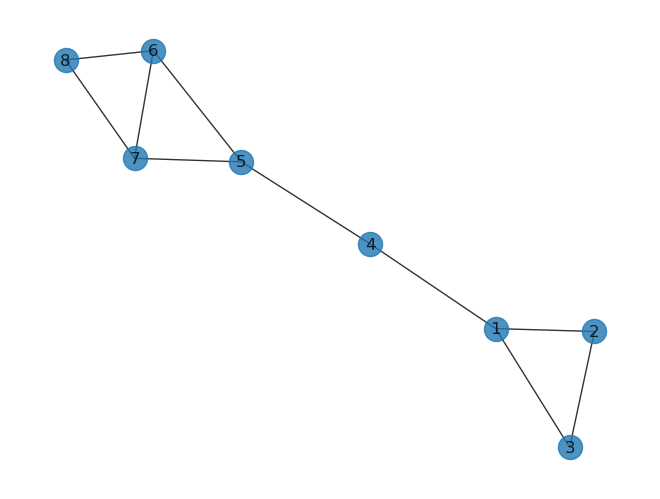

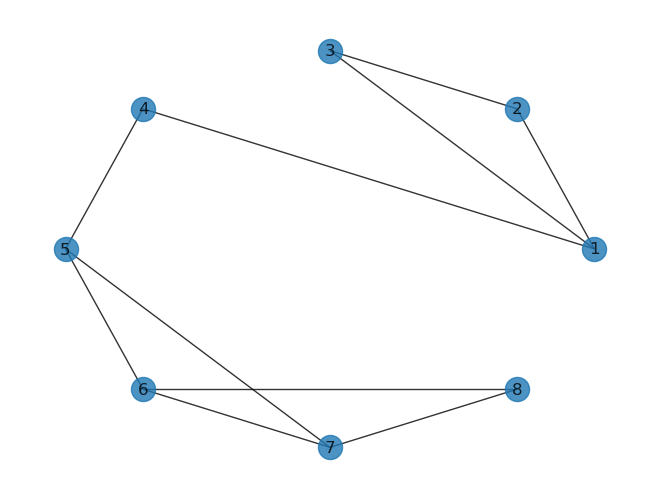

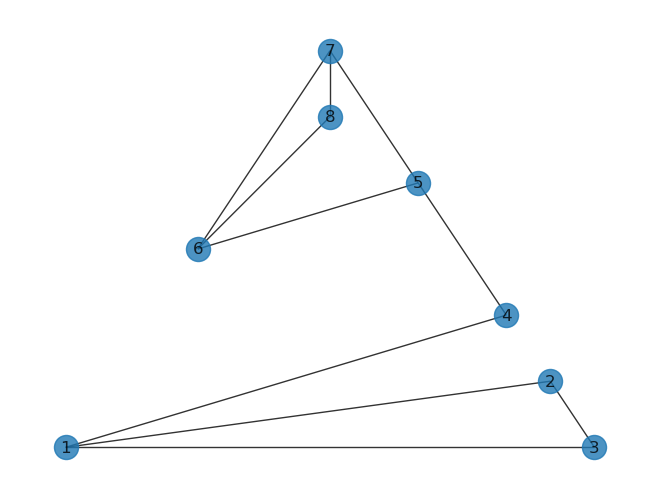

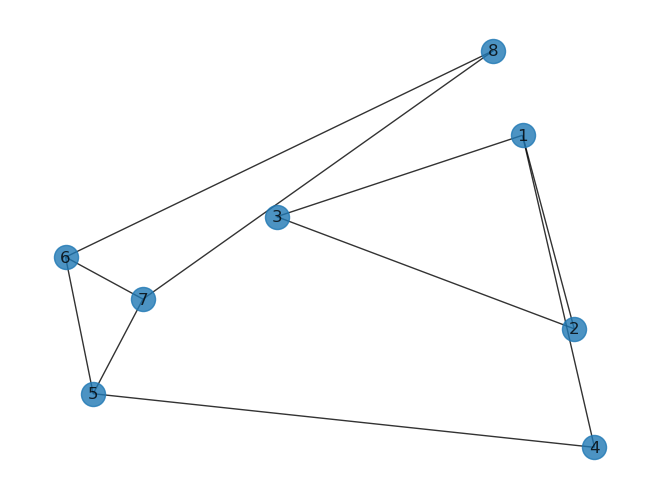

In [175]:
#### Creation of a graph

G = nx.Graph() # for a directed graph use nx.DiGraph()
G.add_node(1)
G.add_nodes_from(range(2,9))  # add multiple nodes at once

# add edges 
G.add_edge(1,2)
edges = [(2,3), (1,3), (4,1), (4,5), (5,6), (5,7), (6,7), (7,8), (6,8)]
G.add_edges_from(edges)
G.nodes()

print(G) # Overview of the graph
# plot of the graph
nx.draw_spring(G, with_labels=True,  alpha = 0.8)
plt.show()
nx.draw_circular(G, with_labels=True,  alpha = 0.8)
plt.show()
nx.draw_planar(G, with_labels=True,  alpha = 0.8)
plt.show()
nx.draw_random(G, with_labels=True,  alpha = 0.8)
plt.show()


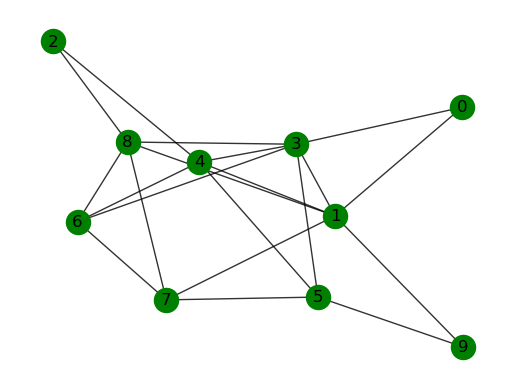

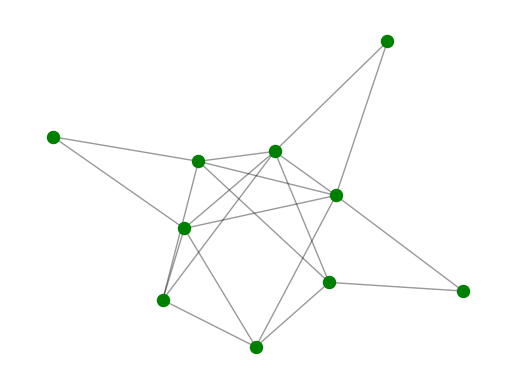

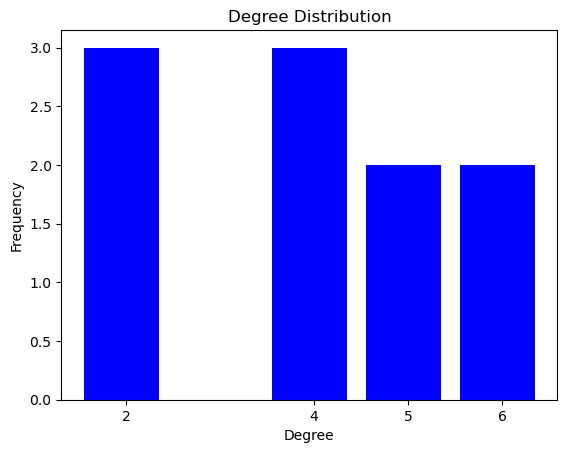

Graph with 10 nodes and 20 edges
Avg. Shortest Path Length: 1.6222
Diameter: 3.0000
Sparsity: 0.4444
Global clustering coefficient aka Transitivity: 0.3380


In [210]:
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    ax.set_xticks([d+0.05 for d in deg])
    ax.set_xticklabels(deg)

def describe_graph(G):
    print(G)
    if nx.is_connected(G):
        print(f"Avg. Shortest Path Length: {nx.average_shortest_path_length(G)}")
        print(f"Diameter: {nx.diameter(G)}") # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print(f"Sparsity: {nx.density(G)}")  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print(f"Global clustering coefficient aka Transitivity: {nx.transitivity(G)}")

# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

### Erdös graph
erG = nx.gnm_random_graph(10, 20)# 10 nodes, 20 edges
visualize_graph(erG, k=0.05, alpha=0.8)
plt.show()
visualize_graph(erG, False, k=0.05, alpha=0.4, node_shape='.')
plt.show()
plot_degree_distribution(erG)
plt.show()
describe_graph(erG)

In [ ]:
## Creation of a graph from a group of edges in df
G =nx.from_pandas_edgelist(df, 'Source', 'Target', edge_attr=None, create_using= nx.Graph())

# Adding attributes to nodes 
nx.set_node_attributes(G, df['Attribute'].to_dict(), 'Name_of_attribute' )
G.nodes[0] # listing of attributes of node 0

# Getting how triadic closure is done on the graph/for individuals
nx.transitivity(G)
nx.clustering(G, [1, 3]) # only look at value for nodes 1 and 3